In [2]:
# 导入库
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from   IPython.core.display import HTML
import numpy as np
from   datetime import datetime, timedelta
from   pandas.tseries.offsets import *


In [4]:
# To do:    在PortfolioConstruction之前处理情感分析原始数据
#           将所有国家在不同网站爬取的文章的分数放到一起计算平均值
# 导入情感数据
df_sentiment = pd.read_csv('../Data/Merged Sentiment Reuters.csv')

# 修改列名
df_sentiment = df_sentiment.rename(columns={
    'LMD_Polarity': 'LMD',
    'HIV4_Polarity': 'HIV4',
    'Vader_Polarity': 'Vader',
    'FinBert_Polarity': 'FinBert'
})

# 展示数据
df_sentiment.head()

,Unnamed: 0,Date,Country,LMD,HIV4,Vader,FinBert
0,0,2012-01-01,Australia,NaN,NaN,NaN,NaN
1,4018,2012-01-01,Canada,NaN,NaN,NaN,NaN
2,8036,2012-01-01,China,NaN,NaN,NaN,NaN
3,12054,2012-01-01,Denmark,NaN,NaN,NaN,NaN
4,16072,2012-01-01,Finland,NaN,NaN,NaN,NaN


In [8]:
# 导入收益率数据
df_return = pd.read_csv('../Data/daily_return.csv')

# 展示数据
df_return.head()

# # 展示为0或者NA的数据的数量
# print('Number of 0 or NA in each column:')
# print(df_return.isin([0, np.nan]).sum())


,Date,New Zealand,United Kingdom,Finland,Norway,United States,Sweden,Korea,Japan,Canada,...,Australia,Germany,France,China,Switzerland,Spain,Denmark,Italy,Singapore,Portugal
0,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-02,-0.010866,-0.207038,0.302897,0.235483,0.489692,0.154354,0.094609,-0.042270,0.178307,...,0.053087,0.393824,-1.345329,0.328191,0.241278,0.536400,0.065521,-0.189497,-0.251753,0.148492
2,2011-12-05,0.077141,-0.460678,-0.474224,-0.158909,-0.084015,-0.179613,0.056292,0.165816,0.227525,...,0.302855,-0.615728,1.099039,0.264403,-0.125720,3.778843,-1.723893,5.259712,-0.012405,3.308727
3,2011-12-06,0.201784,0.810078,0.100602,-0.190226,-0.406179,0.198203,-0.004941,0.066255,-0.330724,...,0.354603,0.150150,-0.863361,-0.157734,0.335027,-0.630513,0.272330,0.715348,0.047384,1.062182
4,2011-12-07,0.187048,0.129148,0.496636,0.290407,0.543003,0.567308,-0.043160,0.002849,0.596567,...,-0.273399,0.762903,0.199724,0.001528,0.198283,-1.476326,-0.028845,-0.948723,-0.251362,1.737582


In [9]:
# 转换日期格式
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], format='%Y-%m-%d')
df_return['Date'] = pd.to_datetime(df_return['Date'], format='%Y-%m-%d')

# 生成日期范围
all_dates = pd.date_range(start='2012-01-01', end='2022-12-30').tolist()
df_return = df_return[df_return['Date'].isin(all_dates)]

# 去掉无用的列
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0'])

# 过滤掉周末的情感数据
df_sentiment = df_sentiment[df_sentiment['Date'].dt.dayofweek < 5]
# 填充NA为0
df_sentiment = df_sentiment.fillna(0)

# Calculate the average sentiment for each country
average_polarity = df_sentiment[['LMD', 'HIV4', 'Vader', 'FinBert']].mean(axis=1)

# Create a new DataFrame to store the results
df_sentiment_aver = pd.DataFrame({
    'Date': df_sentiment['Date'],
    'Country': df_sentiment['Country'],
    'Average': average_polarity
})

# Rank the average sentiment for each day
df_sentiment_aver['Average_Rank'] = df_sentiment_aver.groupby('Date')['Average'].rank(ascending=False, method='first')


/var/folders/80/7fqc_wn17xz3qh01msrt026h0000gn/T/ipykernel_2610/3256507095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment2['Date'] = pd.to_datetime(df_sentiment2['Date'], utc=True).dt.date


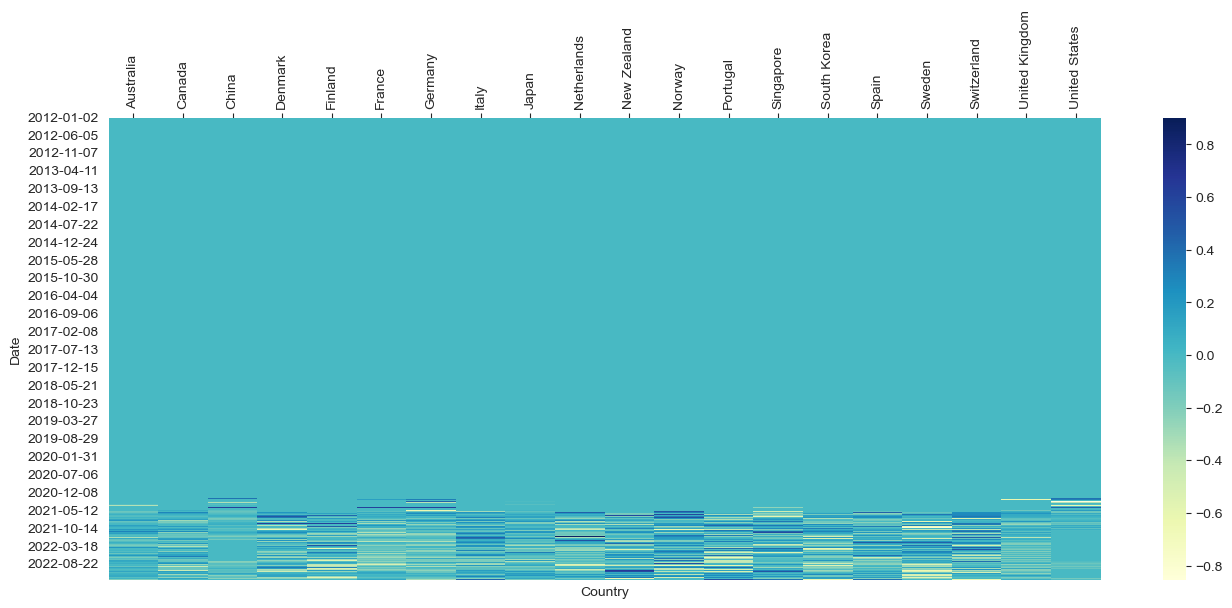

In [10]:
# 展示数据的map图
df_sentiment2 = df_sentiment_aver[['Date', 'Country', 'Average']]
df_sentiment2['Date'] = pd.to_datetime(df_sentiment2['Date'], utc=True).dt.date
df_sentiment2 = pd.pivot_table(df_sentiment2, index=["Date"],columns="Country",values="Average")
ax = sn.heatmap(df_sentiment2, cmap="YlGnBu")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(16, 6)

In [12]:
# 将Average_Polarity和Return赋给merged_data
merged_data = pd.merge(df_sentiment_aver, df_sentiment, on=['Date', 'Country'], how='outer')
df_return_melted = df_return.melt(id_vars='Date', var_name='Country', value_name='Return')
merged_data = pd.merge(merged_data, df_return_melted, on=['Date', 'Country'], how='outer')
column_order = ['Date', 'Country', 'LMD', 'HIV4', 'Vader', 'FinBert', 'Average', 'Return']
merged_data = merged_data[column_order]

merged_data

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
0,2012-01-02,Australia,0.0,0.0,0.0,0.0,0.0,0.006376
1,2012-01-02,Canada,0.0,0.0,0.0,0.0,0.0,0.005310
2,2012-01-02,China,0.0,0.0,0.0,0.0,0.0,0.009373
3,2012-01-02,Denmark,0.0,0.0,0.0,0.0,0.0,-0.338765
4,2012-01-02,Finland,0.0,0.0,0.0,0.0,0.0,-0.558697
...,...,...,...,...,...,...,...,...
60265,2022-12-26,Korea,NaN,NaN,NaN,NaN,NaN,-0.663004
60266,2022-12-27,Korea,NaN,NaN,NaN,NaN,NaN,0.253145
60267,2022-12-28,Korea,NaN,NaN,NaN,NaN,NaN,-0.524433
60268,2022-12-29,Korea,NaN,NaN,NaN,NaN,NaN,-0.515474


In [13]:
merged_data = merged_data.dropna(subset=['Return'])

In [14]:
correlations = merged_data.corr().unstack().sort_values(ascending=False) # Build correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
correlations.columns = ['Return', 'Method', 'Correlation with Returns'] # Label it
result = correlations.query("Return == 'Return' & Method != 'Return'") # Filter by variable
result = result.drop(['Return'], axis = 1)

result

/var/folders/80/7fqc_wn17xz3qh01msrt026h0000gn/T/ipykernel_2610/3990684459.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_data.corr().unstack().sort_values(ascending=False) # Build correlation matrix


,Method,Correlation with Returns
19,LMD,0.030321
20,FinBert,0.018363
23,Average,-0.002249
25,Vader,-0.024705
29,HIV4,-0.035206


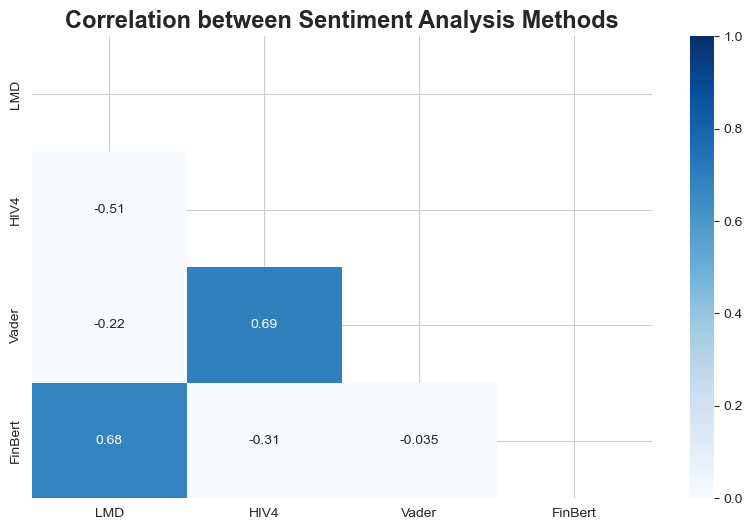

In [15]:
dfMethodCorrelation = pd.DataFrame(merged_data,columns=['LMD','HIV4','Vader', 'FinBert'])
corrMatrixPearson = dfMethodCorrelation.corr()
mask = np.triu(corrMatrixPearson)
sn.heatmap(corrMatrixPearson, annot=True, vmin=0, vmax=1, cmap="Blues", mask=mask)
plt.title("Correlation between Sentiment Analysis Methods", fontsize=17, fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(10, 6)

In [16]:
strategies = ['LMD','HIV4','Vader', 'FinBert', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(strategies)):
    for i in range(0, len(all_dates)):
        sample_df = merged_data[merged_data['Date'] == all_dates[i]]
        sample_df = sample_df.dropna(subset=[strategies[x]])
        total_return = 0
        total_count = 0

        # 添加一个微小的随机扰动以避免并列
        # sample_df[strategies[x]] = sample_df[strategies[x]].apply(lambda x: x + np.random.uniform(-0.00001,0.00001))

        large_df = sample_df.nlargest(5, strategies[x])
        small_df = sample_df.nsmallest(5, strategies[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0:
            total_ret_long = total_ret_long / count_long

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][all_dates[i]] = total_return


In [22]:
# 测试异常数据例如:2022/12/22, LMD收益为-24%
temp = merged_data[merged_data['Date'] == all_dates[-9]]
temp = temp.dropna(subset=[strategies[0]])
temp_large_df = temp.nlargest(5, strategies[0])
temp_small_df = temp.nsmallest(5, strategies[0])

temp_large_df

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
57269,2022-12-22,Netherlands,0.083333,0.287231,0.360233,0.297397,0.257049,-0.418246
57271,2022-12-22,Norway,0.000000,0.000000,0.000000,0.000000,0.000000,-0.491399
57263,2022-12-22,Denmark,-0.125000,0.542857,0.967800,-0.590588,0.198767,-0.503944
57260,2022-12-22,Australia,-0.163927,0.259158,0.234175,-0.349827,-0.005105,-0.597586
57270,2022-12-22,New Zealand,-0.194406,0.386580,0.520725,-0.165761,0.136785,0.213829


In [23]:
temp_small_df

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
57272,2022-12-22,Portugal,-1.000000,0.833333,0.939500,0.611288,0.346030,-0.337550
57273,2022-12-22,Singapore,-0.692308,0.056604,-0.836900,-0.962102,-0.608677,0.007929
57267,2022-12-22,Italy,-0.583120,0.251594,0.644407,-0.261736,0.012786,-0.346633
57277,2022-12-22,Switzerland,-0.555555,0.230769,0.952400,0.775285,0.350725,-0.050781
57262,2022-12-22,China,-0.504616,0.189549,0.248669,-0.478137,-0.136134,0.134168


In [18]:
new_portfolio_25 = pd.DataFrame(dict_ret).transpose()
new_portfolio_25 = new_portfolio_25.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'Vader', 3: 'FinBert', 4: 'Average'})
new_portfolio_25.reset_index(inplace=True)
new_portfolio_25.rename(columns={'index': 'Date'}, inplace=True)

# newportfolio25.to_csv('25percentportfolio.csv')

In [19]:
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
IR_dict = {}

for strategy in strategies:
    returns = new_portfolio_25[strategy]
    average_return = np.mean(returns)
    std_return = np.std(returns)
    IR = average_return / std_return
    IR_dict[strategy] = IR

print(IR_dict)

{'LMD': -0.02042417073234666, 'HIV4': 0.00017305100848652062, 'Vader': -0.015317361284677065, 'FinBert': -0.005691855764941161, 'Average': -0.004674611329385536}


In [20]:
new_portfolio_25

,Date,LMD,HIV4,Vader,FinBert,Average
0,2012-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2012-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2,2012-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
3,2012-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
4,2012-01-05,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
4012,2022-12-26,0.071507,-8.902190,10.927833,-0.073808,10.847614
4013,2022-12-27,-1.410609,-7.964340,-36.201345,-41.415750,-48.684618
4014,2022-12-28,0.997400,-13.754552,-16.038660,26.966135,-0.945992
4015,2022-12-29,-18.676964,21.731193,13.033375,7.471408,13.033375


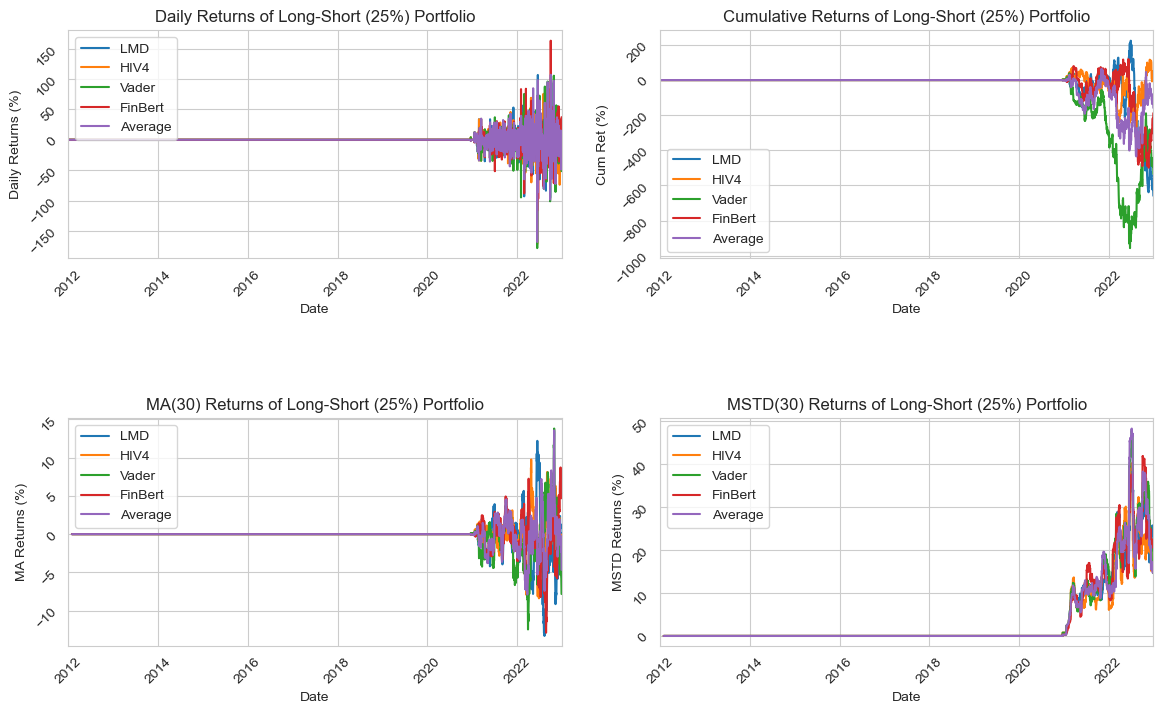

In [21]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.7)
new_portfolio_25 = new_portfolio_25.set_index('Date')
new_portfolio_25.plot(ax=ax1, title='Daily Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
new_portfolio_25.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
new_portfolio_25.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
new_portfolio_25.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
ax3.tick_params(labelrotation=45)
ax4.tick_params(labelrotation=45)